In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-23 23:10:28.169526: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 23:10:41.856927: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-23 23:10:41.877513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-23 23:10:41.877583: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 23:10:41.881162: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-23 23:10:41.884611: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [192]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [193]:
data.shape

(2, 100, 100, 769)

In [194]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [195]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [196]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

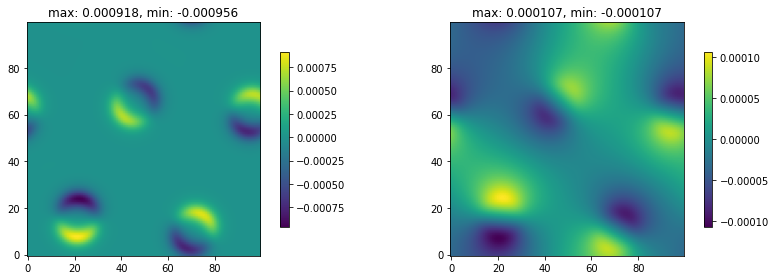

In [197]:
index = -1
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"max: {np.max(c_t[0,:,:, index]):.6f}, min: {np.min(c_t[0,:,:, index]):.6f}")
plt.imshow(c_t[0,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title(f"max: {np.max(c_t[1,:,:, index]):.6f}, min: {np.min(c_t[1,:,:, index]):.6f}")
plt.imshow(c_t[1,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.tight_layout()
plt.show()

In [198]:
data.shape

(2, 100, 100, 769)

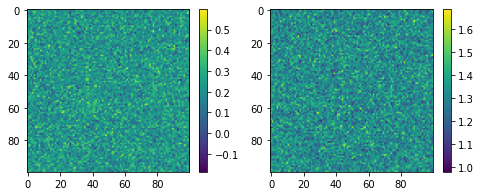

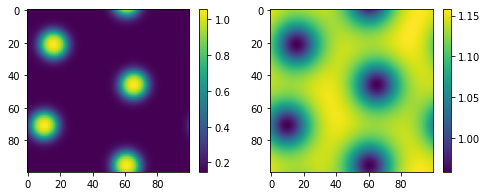

In [199]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [200]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
outputs_correction_fact = [1, 1, .25, .25, 1000, 2.5, 2.5, 10000]
xx_factors = [1, 1]#[.25, 2.5]
yy_factors = [1, 1]#[.25, 2.5]
t_factors = [1, 1]#[1000, 10000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [201]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [202]:
T

769

In [203]:
c_t.shape

(2, 100, 100, 768)

In [204]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [205]:
T

2

In [206]:
data.shape

(2, 100, 100, 2)

In [207]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)

# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [208]:
relative_mean_denominators = np.concatenate([np.mean(obs_outputs**2, axis=0),
                                             np.mean(der_u_outputs**2, axis=0),
                                             np.mean(der_v_outputs**2, axis=0), 
                                             [1.0, 1.0]])

In [209]:
relative_mean_denominators.shape

(10,)

In [210]:
obs_X.shape

(32, 5)

In [211]:
c_xx.shape

(2, 100, 100, 2)

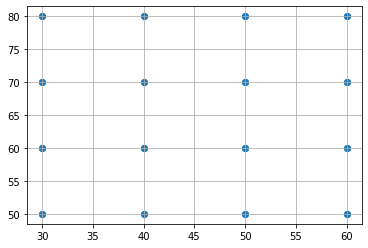

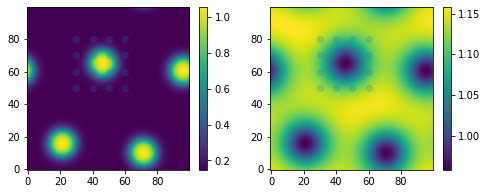

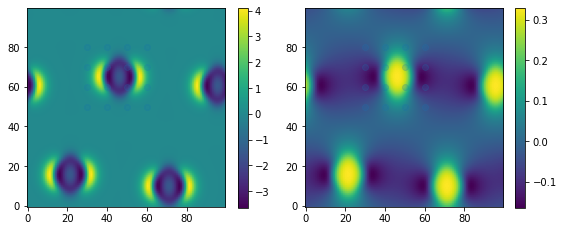

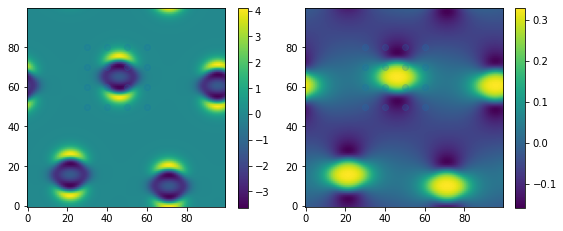

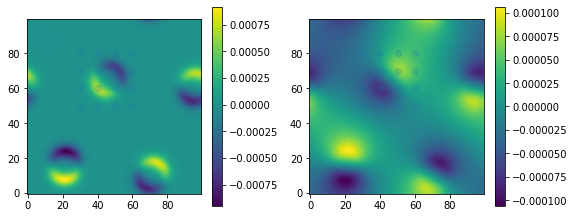

In [212]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

In [213]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, der_X, pde_X)

In [214]:
ds_obs.sizes

array([32, 32, 32])

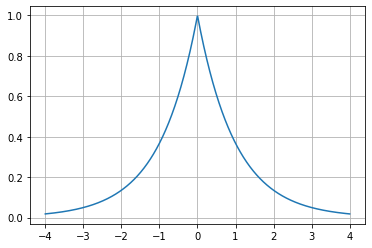

In [215]:
def x_3(x):
    
    return np.where(x < -1 , 
                    np.where(x < -1, -1/(1+x**-4), x**3/2), 
                    np.where(x < 1, x**3/2, 1/(1+x**-4))
                    )

def exp_(x):
    
    #return np.where(x > 0, np.exp(-x), np.exp(x))
    return np.exp(-np.abs(x))

xs = np.linspace(-4, 4, 1000)
plt.plot(xs, exp_(xs))
plt.grid()

In [216]:
class NN2(tf.Module):
    def __init__(self, layers, lb, ub, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)
        self.lb = lb
        self.ub = ub
        self.dtype = dtype
        self.__version__ = 0.1
        self.build()

    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)
            

        self.Ws = weights
        self.bs = biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.dtype), dtype=self.dtype
        )

    @tf.function
    def net(self, inputs):
        def exp_(x):            
            #ret = tf.math.exp(x)           
            #return tf.minimum(ret, tf.math.exp(4.0) )
            return tf.math.exp(-tf.math.abs(x)) 
            
            
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, b in zip(self.Ws, self.bs):            
            outputs = tf.add(tf.matmul(H, W), b)
            #H = tf.tanh(outputs)
            H = exp_(outputs)

        return outputs

    def __call__(self, inputs):
        """Defines the computation from inputs to outputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """
        X = tf.cast(inputs, self.dtype)
        return self.net(X)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """
        partials = [tape.gradient(outputs[i], inputs) for i in range(len(outputs))]
        return partials

    def copy(self):
        return copy.deepcopy(self)

    def save(self, path_dir, name):
        path = pathlib.PurePath(path_dir).joinpath(name)
        # tf.saved_model.save(self, str(path))
        #
        # import os
        # if not pathlib.Path(path.joinpath(name)).exists():
        #   os.makedirs(path.joinpath(name))
        with open(f"{str(path)}.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def restore(cls, path_dir, name):
        path = pathlib.PurePath(path_dir).joinpath(name)
        # asset = tf.saved_model.load(str(path))
        with open(f"{str(path)}.pkl", "rb") as f:
            model = pickle.load(f)
        return model

In [217]:
class Koch_Meinhard2(tu.Loss):
    def __init__(
        self,
        dtype,
        D_u: PDE_Parameter,
        D_v: PDE_Parameter,
        sigma_u: PDE_Parameter,
        sigma_v: PDE_Parameter,
        mu_u: PDE_Parameter,
        rho_u: PDE_Parameter,
        rho_v: PDE_Parameter,
        kappa_u: PDE_Parameter,
        outputs_correction_fact=(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0),
        regularise=True,
        print_precision=".5f",
    ):
        """Koch_Meinhard PDE loss

        if the parameter is None, it becomes traiable with initial value set as init_vale,
        otherwise, it will be a constant
        alpha_u and alpha_v are scales that we use to normalise the u and v.
        """

        super().__init__(
            name="Loss_Koch_Meinhard",
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("res u", "res v"),
            print_precision=print_precision,
        )

        self._trainables_ = ()

        self.D_u = D_u.build()
        self._trainables_ += D_u.trainable
        self.D_v = D_v.build()
        self._trainables_ += D_v.trainable
        self.sigma_u = sigma_u.build()
        self._trainables_ += sigma_u.trainable
        self.sigma_v = sigma_v.build()
        self._trainables_ += sigma_v.trainable
        self.mu_u = mu_u.build()
        self._trainables_ += mu_u.trainable
        self.rho_u = rho_u.build()
        self._trainables_ += rho_u.trainable
        self.rho_v = rho_v.build()
        self._trainables_ += rho_v.trainable
        self.kappa_u = kappa_u.build()
        self._trainables_ += kappa_u.trainable
        
        assert len(outputs_correction_fact) == 8
        self.outputs_correction_fact = [tf.constant(i, dtype=dtype) for i in outputs_correction_fact]

    @tf.function
    def residual(self, pinn, x):

        (y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) = self.derivatives(pinn, x)
        u *= self.outputs_correction_fact[0]
        v *= self.outputs_correction_fact[1]
        u_xx *= self.outputs_correction_fact[2]
        u_yy *= self.outputs_correction_fact[3]
        u_t *= self.outputs_correction_fact[4]
        v_xx *= self.outputs_correction_fact[5]
        v_yy *= self.outputs_correction_fact[6]
        v_t *= self.outputs_correction_fact[7]

        D_u = self.D_u.get_value(x)
        D_v = self.D_v.get_value(x)
        sigma_u = self.sigma_u.get_value(x)
        sigma_v = self.sigma_v.get_value(x)
        mu_u = self.mu_u.get_value(x)
        rho_u = self.rho_u.get_value(x)
        rho_v = self.rho_v.get_value(x)
        kappa_u = self.kappa_u.get_value(x)

        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = u_t - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u
        f_v = v_t - D_v * (v_xx + v_yy) + rho_v * f - sigma_v

        return (f_u, f_v)

In [219]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 64, 64, 64, 64, 2]

pinnKM = NN2(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard2(
                    dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    #D_u=PDE_Parameter("D_u", Parameter_Type.VARIABLE, 1.0, dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #D_v=PDE_Parameter("D_v", Parameter_Type.VARIABLE,  1.0, dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

                    #                    dtype=pinnKM.dtype),
    outputs_correction_fact = [1, 1, 1, 1, 1, 1, 1, 1],#[1, 1, 4, 4, 1/1000, 0.4, 0.4, 1/10000],
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v"))

#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
der_loss = Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, der_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [220]:
modelKM.loss_values

array([array([0., 0.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0.])],
      dtype=object)

In [221]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 16,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators)
modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 10000+1,
                          batch_size = 16,
                          dataset = ds_obs,
                          print_interval=500,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 4052503.105024337769, total regularised loss: 13.411104202271
Observation_Loss -> 
(1)  u: 0.511617302895 (2)  v: 1.831039369106 
Derivatives_Loss -> 
(3)  u_xx: 1.000035494566 (4)  u_yy: 0.998991161585 (5)  u_t: 224402.937500000000 
(6)  v_xx: 0.997992813587 (7)  v_yy: 1.000932604074 (8)  v_t: 1801840.562500000000 

Loss_Koch_Meinhard -> 
(9)  res u: 0.675224900246 (10)  res v: 1.034630656242 
sigma_u: 0.99900 sigma_v: 0.99900 mu_u: 1.00098 rho_u: 1.00097 
rho_v: 0.99902 kappa_u: 1.00091 
Time taken: 8.95s

Start of epoch 100
total loss: 1403768.618742674589, total regularised loss: 6.824300765991
Observation_Loss -> 
(1)  u: 2.211701750755 (2)  v: 0.002667093999 
Derivatives_Loss -> 
(3)  u_xx: 0.999096333981 (4)  u_yy: 1.000496238470 (5)  u_t: 50798.218750000000 
(6)  v_xx: 1.034942984581 (7)  v_yy: 1.018423497677 (8)  v_t: 651079.468750000000 

Loss_Koch_Meinhard -> 
(9)  res u: 0.169502735138 (10)  res v: 0.175499655306 
sigma_u: 0.90861 sigma_v: 0.91


Start of epoch 1600
total loss: 443353.112856124761, total regularised loss: 5.606238365173
Observation_Loss -> 
(1)  u: 0.396501824260 (2)  v: 0.001592373999 
Derivatives_Loss -> 
(3)  u_xx: 0.997387319803 (4)  u_yy: 0.997802555561 (5)  u_t: 10095.662353515625 
(6)  v_xx: 0.997962146997 (7)  v_yy: 0.995120912790 (8)  v_t: 211576.503906250000 

Loss_Koch_Meinhard -> 
(9)  res u: 0.000975086237 (10)  res v: 0.001108784054 
sigma_u: 0.41858 sigma_v: 0.18458 mu_u: 1.45507 rho_u: 0.56864 
rho_v: 1.60053 kappa_u: 0.26199 
Time taken: 5.01s

Start of epoch 1700
total loss: 246984.282629519817, total regularised loss: 5.539983749390
Observation_Loss -> 
(1)  u: 0.399329125881 (2)  v: 0.002270387718 
Derivatives_Loss -> 
(3)  u_xx: 0.984556019306 (4)  u_yy: 0.985790312290 (5)  u_t: 10546.875488281250 
(6)  v_xx: 1.003169029951 (7)  v_yy: 1.001918613911 (8)  v_t: 112940.886718750000 

Loss_Koch_Meinhard -> 
(9)  res u: 0.000903703040 (10)  res v: 0.000530295380 
sigma_u: 0.40141 sigma_v: 0.171


Start of epoch 500
total loss: 63916.154977905564, total regularised loss: 4.886320114136
Observation_Loss -> 
(1)  u: 0.210106126964 (2)  v: 0.001220097125 
Derivatives_Loss -> 
(3)  u_xx: 0.883836537600 (4)  u_yy: 0.864421486855 (5)  u_t: 17692.985351562500 
(6)  v_xx: 0.978170067072 (7)  v_yy: 0.975054830313 (8)  v_t: 14261.172363281250 

Loss_Koch_Meinhard -> 
(9)  res u: 0.003862607758 (10)  res v: 0.002925118315 
sigma_u: 0.32370 sigma_v: 0.09942 mu_u: 1.34042 rho_u: 0.71705 
rho_v: 1.50249 kappa_u: 0.35580 
Time taken: 24.99s

Start of epoch 1000
total loss: 30688.669416905846, total regularised loss: 4.869649410248
Observation_Loss -> 
(1)  u: 0.164361789823 (2)  v: 0.001027638325 
Derivatives_Loss -> 
(3)  u_xx: 0.882815092802 (4)  u_yy: 0.863399922848 (5)  u_t: 8826.916259765625 
(6)  v_xx: 0.984601110220 (7)  v_yy: 0.980628967285 (8)  v_t: 6513.533447265625 

Loss_Koch_Meinhard -> 
(9)  res u: 0.004073347198 (10)  res v: 0.004112859722 
sigma_u: 0.30672 sigma_v: 0.08454 mu_


Start of epoch 8500
total loss: 65768.789538195037, total regularised loss: 4.799344062805
Observation_Loss -> 
(1)  u: 0.000042962298 (2)  v: 0.000014593539 
Derivatives_Loss -> 
(3)  u_xx: 0.882195562124 (4)  u_yy: 0.862659394741 (5)  u_t: 98.517734527588 
(6)  v_xx: 0.968669444323 (7)  v_yy: 0.956002742052 (8)  v_t: 32782.208007812500 

Loss_Koch_Meinhard -> 
(9)  res u: 0.000005563688 (10)  res v: 0.000174727997 
sigma_u: 0.07403 sigma_v: 0.00000 mu_u: 0.66207 rho_u: 1.41023 
rho_v: 0.23719 kappa_u: 1.50268 
Time taken: 24.42s

Start of epoch 9000
total loss: 81128.457458819976, total regularised loss: 4.799277305603
Observation_Loss -> 
(1)  u: 0.000024315355 (2)  v: 0.000015570418 
Derivatives_Loss -> 
(3)  u_xx: 0.882188051939 (4)  u_yy: 0.862661927938 (5)  u_t: 119.725131988525 
(6)  v_xx: 0.967188715935 (7)  v_yy: 0.955246418715 (8)  v_t: 40440.835937500000 

Loss_Koch_Meinhard -> 
(9)  res u: 0.000006306356 (10)  res v: 0.000167592865 
sigma_u: 0.07403 sigma_v: 0.00000 mu_u:

In [ ]:
'D_u': 0.01 'D_v': 1.0, 'sigma_u': 0.1, 'sigma_v': 0.1, 
'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'kappa_u': 1.0

In [26]:
print(pde_resKM.trainables_str())

D_u: 0.01072 D_v: 1.31256 sigma_u: 0.10728 sigma_v: 0.13125 
mu_u: 1.07268 rho_u: 2.09130 rho_v: 1.96855 kappa_u: 0.99959 



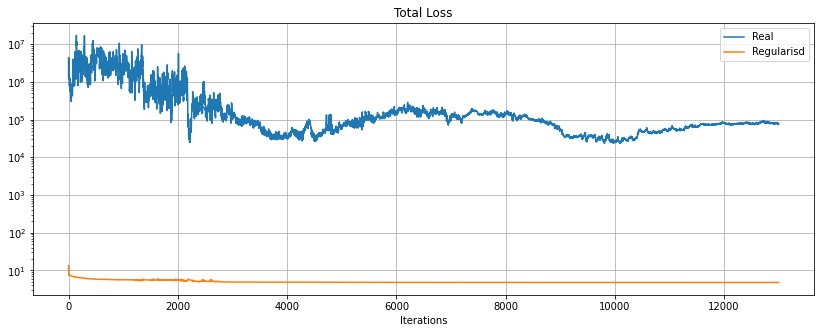

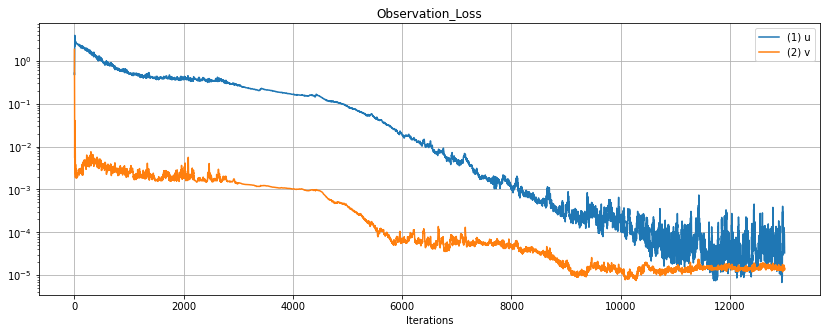

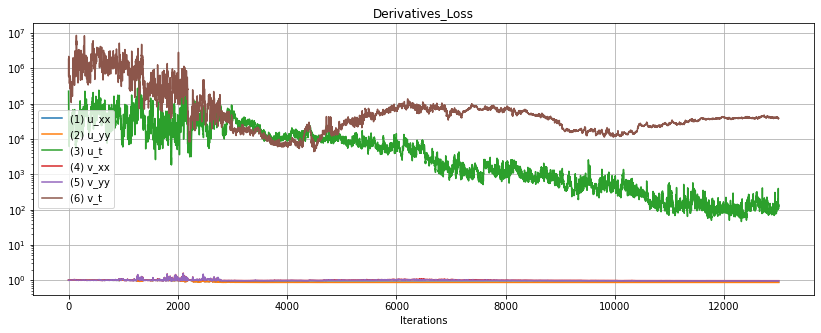

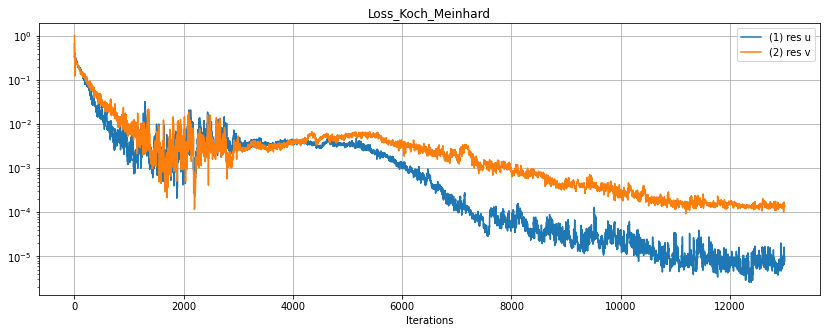

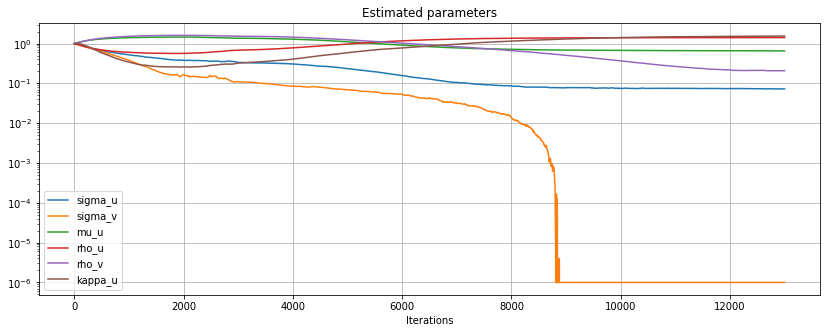

In [222]:
plot_result(merge_dict(results_KM, results_KM2), 
           modelKM, start=0 ,skip=1, param_names=pde_resKM.parameter_names())

In [24]:
modelKM = tu.TINN.restore(".", "patch_points_parameter_estimation_derivatives_outputs_100000", ds_obs)
pinnKM = modelKM.pinn
obs_loss = modelKM.losses[0]
pde_resKM = modelKM.losses[1]

2022-12-19 20:46:19.243793: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-19 20:46:19.748658: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [66]:
def norm_params2(result, simulation):
    D_u = result["D_u"] if "D_u" in result.keys() else simulation.Ds[0]
    D_v = result["D_v"] if "D_v" in result.keys() else simulation.Ds[1]
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    D_u2 = simulation.Ds[0]
    D_v2 = simulation.Ds[1]
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((D_u-D_u2)**2 + 
            (D_v-D_v2)**2 +
            (sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

In [67]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2), 
             simulation))
plt.yscale('log')
plt.ylim([0.33, .4])
plt.grid()
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [82]:
test_d = obs_X[:,:3].astype(np.float32)

In [83]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[0.0010286057, 0.00045741763]
[0.00102861 0.00045742]
[0.03207188 0.02138732]


In [85]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [88]:
(y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) =  derivatives(pinnKM,test_d)


u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [89]:
der_u_outputs.shape

(32, 3)

In [90]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.26708035739989777
0.28122984023255215
0.21912599104358976
0.2852286008237122
0.28565928669792917
0.3418169480853654


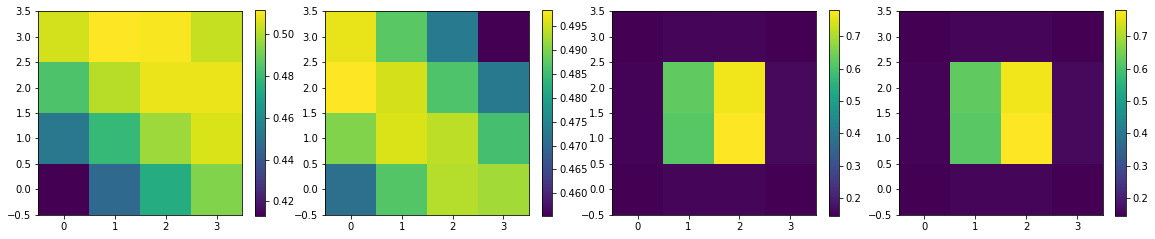

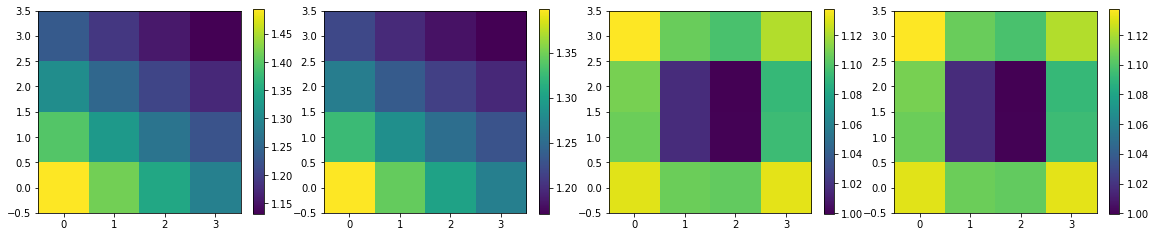

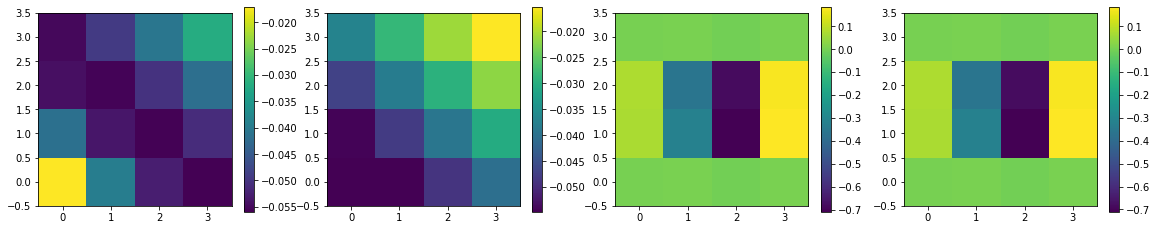

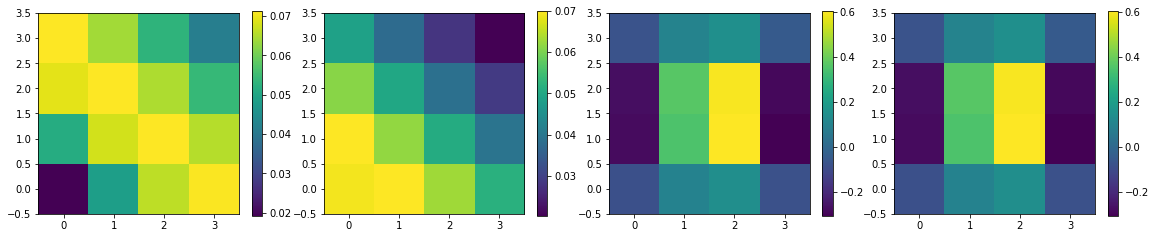

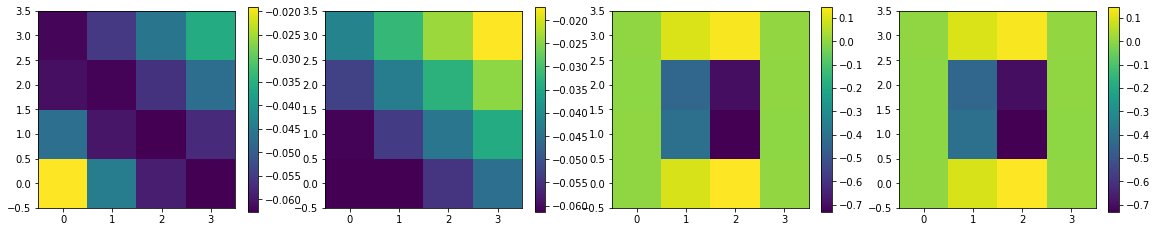

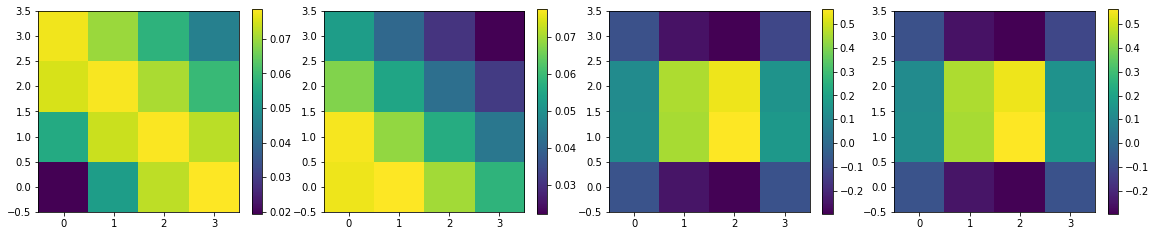

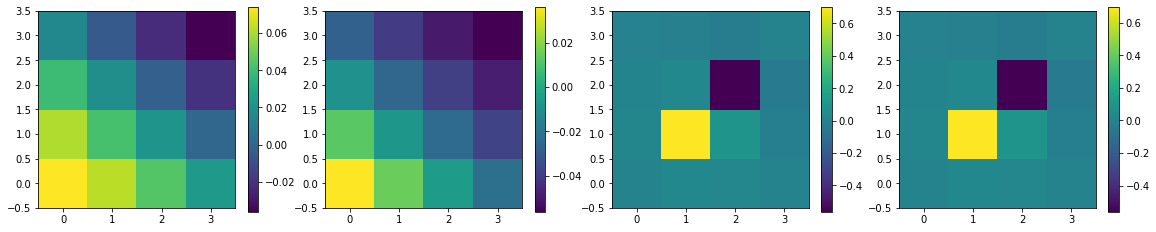

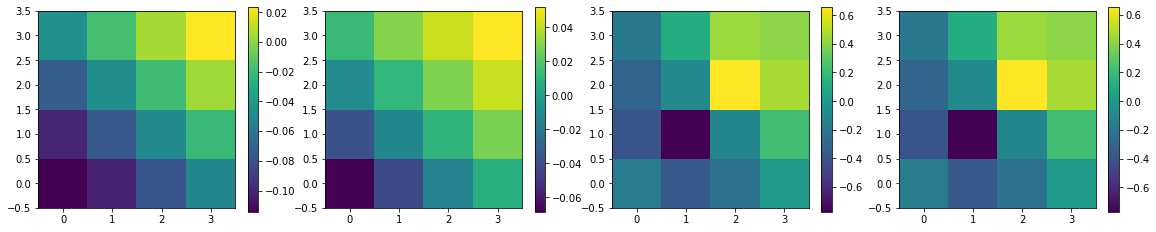

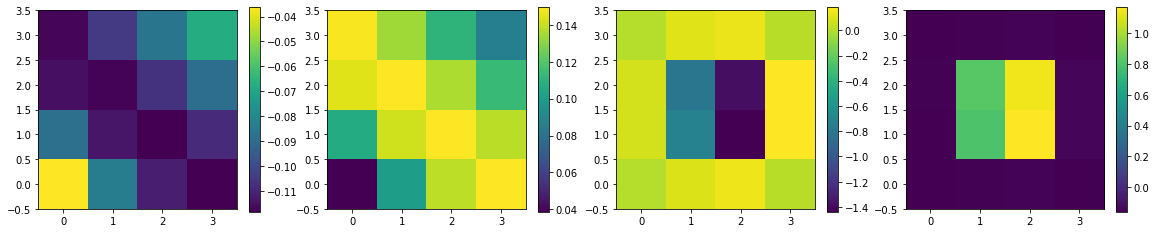

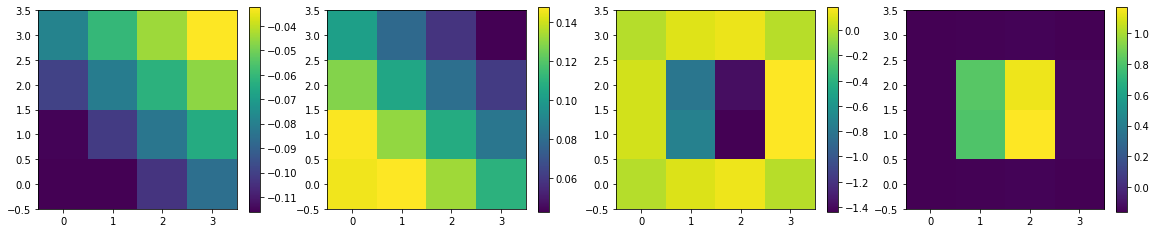

In [91]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [43]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [338]:
params = np.array([rho_u, D, rho_v])

In [354]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.D.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0]])

In [355]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_sol = np.vstack((np.c_[f_sol,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2,  vxxyy_sol, -f_sol]))


u_dt_sol = (u_t.numpy()/100).flatten()
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol-u_sol+1, -v_dt_sol+1)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [356]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

0.012888034596179841

In [357]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

8.206002896477086e-05

In [358]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([1.95058623e-02, 9.77675650e+01, 1.47502555e-02])

In [359]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

4.9839658476115134e-05

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

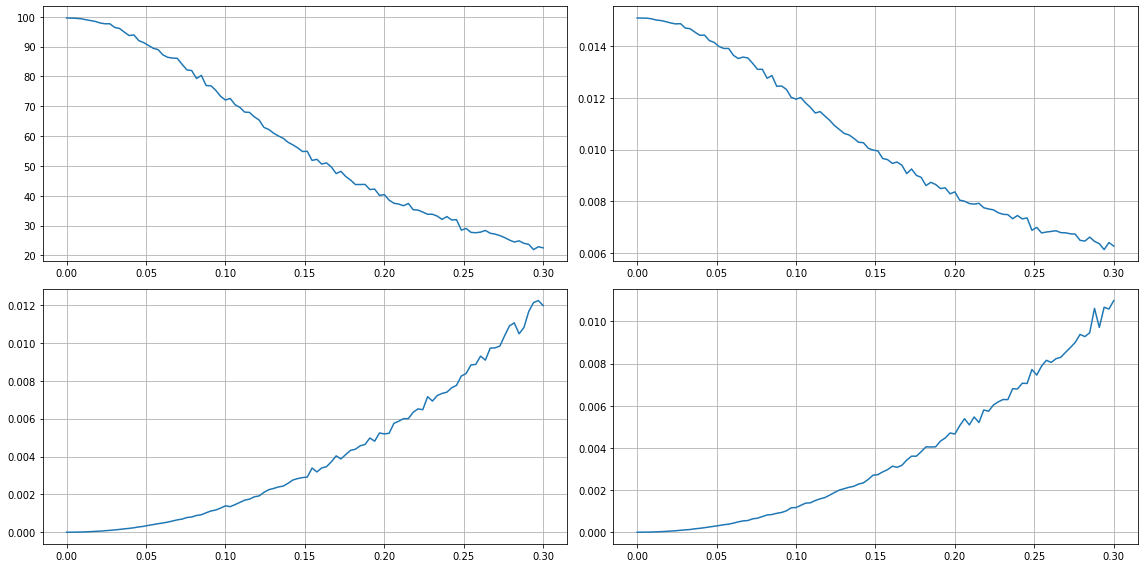

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

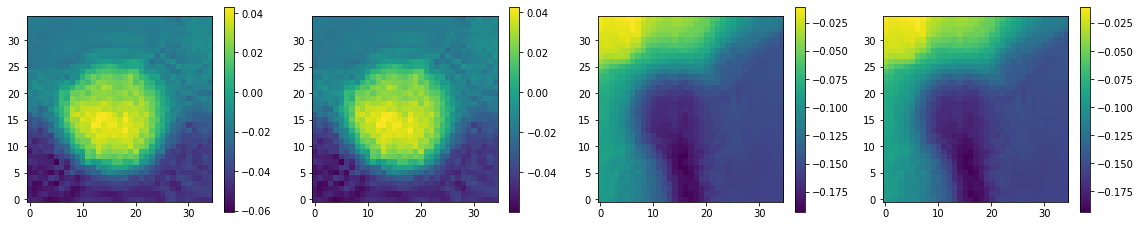

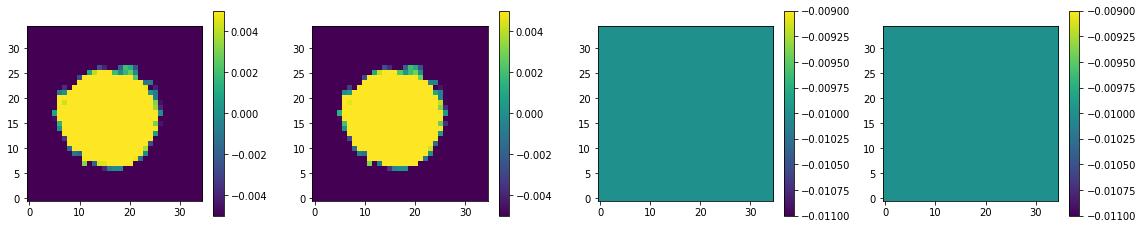

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

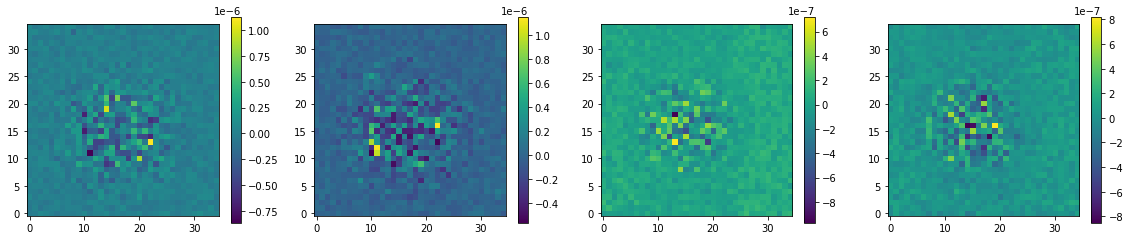

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

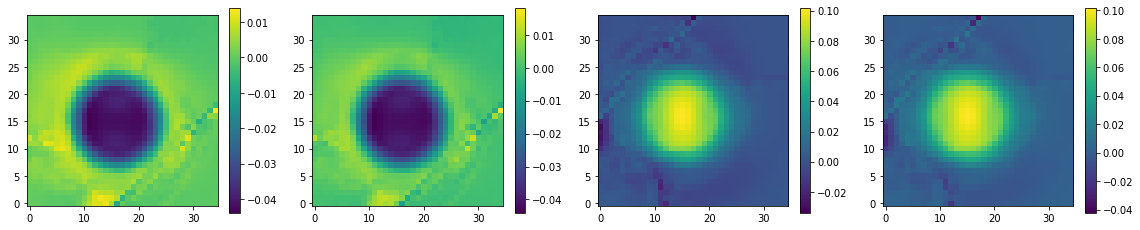

In [161]:
p(res1,res2,res3,res4)

In [380]:
import rdsolver

In [403]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 2*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_resKM.sigma_u.get_value(0).numpy()[0]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(0).numpy()[0]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(0).numpy()[0]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(0).numpy()[0],
          pde_resKM.rho_v.get_value(0).numpy()[0],
          pde_resKM.kappa_u.get_value(0).numpy()[0])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


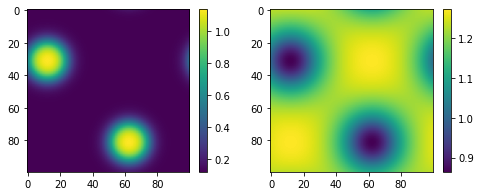

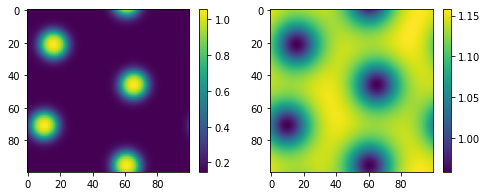

In [406]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [388]:
simulation

Simulation(name='Koch_Meinhardt_9', n=(100, 100), L=(8, 8), Ds=(0.01, 1.0), dt=0.001, t_start=0, t_end=768.0, t_steps=769, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'sigma_u': 0.1, 'sigma_v': 0.1}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.01, 0.01, 0.01, 0.001, 0.001), same_init=True, c0=None)

In [421]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 4*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = 4*simulation.parameters["sigma_u"]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = simulation.parameters["sigma_v"]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -4*simulation.parameters["mu_u"]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (4*simulation.parameters["rho_u"],
          simulation.parameters["rho_v"],
          simulation.parameters["kappa_u"])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]


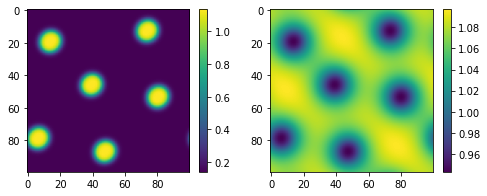

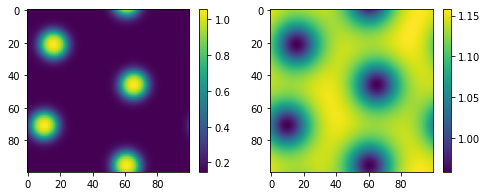

In [422]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [407]:
print(pde_resKM.trainables_str())

sigma_u: 0.03358 sigma_v: 0.08917 mu_u: 0.38960 rho_u: 0.74692 
rho_v: 1.29434 kappa_u: 0.75477 


In [408]:
simulation.parameters

{'kappa_u': 1.0,
 'mu_u': 1.0,
 'rho_u': 1.95,
 'rho_v': 1.5,
 'sigma_u': 0.1,
 'sigma_v': 0.1}

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

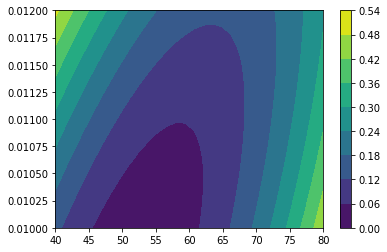

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

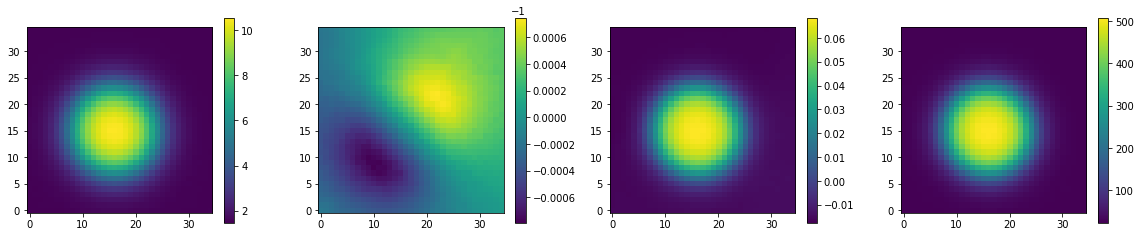

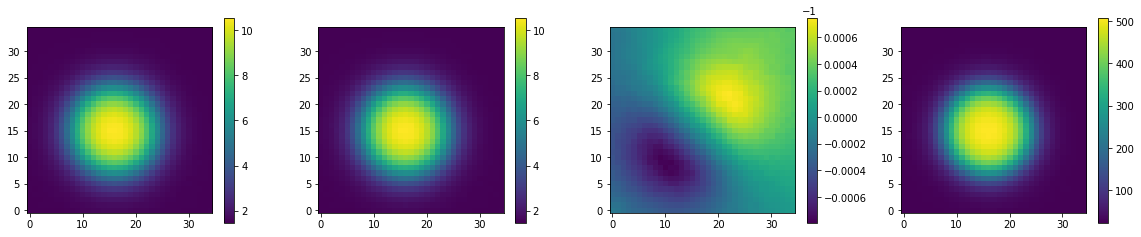

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)